In [ ]:
##10608912.txt

Sentence: she keeps me warm

Author's Note:

So, the lack of Columbia and Magenta centered fics is more than a little alarming.
Characters: ['Magenta', 'Columbia']
Score: 4

Sentence: It is safe to say that they must've cared for each other at least a little bit, despite Magenta virtually not giving a shit when Riff shoots Columbia with the anti matter gun.
Characters: ['Riff Raff', 'Magenta', 'Columbia']
Score: 17

Sentence: Luckily, Riff Raff and Frank were able to fix up the broken down truck that sat parked and abandoned near the castle.
Characters: ['Frank N. Furter', 'Riff Raff']
Score: 8

Sentence: Riff Raff and Magenta never made this a habit back home.
Characters: ['Riff Raff', 'Magenta']
Score: 4

Sentence: With playing their parts, come new uniforms for Magenta and Riff Raff.
Characters: ['Riff Raff', 'Magenta']
Score: 12

Sentence: The joke's on Frank, because Riff rather likes his fingerless gloves.
Characters: ['Frank N. Furter', 'Riff Raff']
Score: 14

Sentence: "Magenta

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_36411/3170801709.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_36411/3170801709.py:116: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


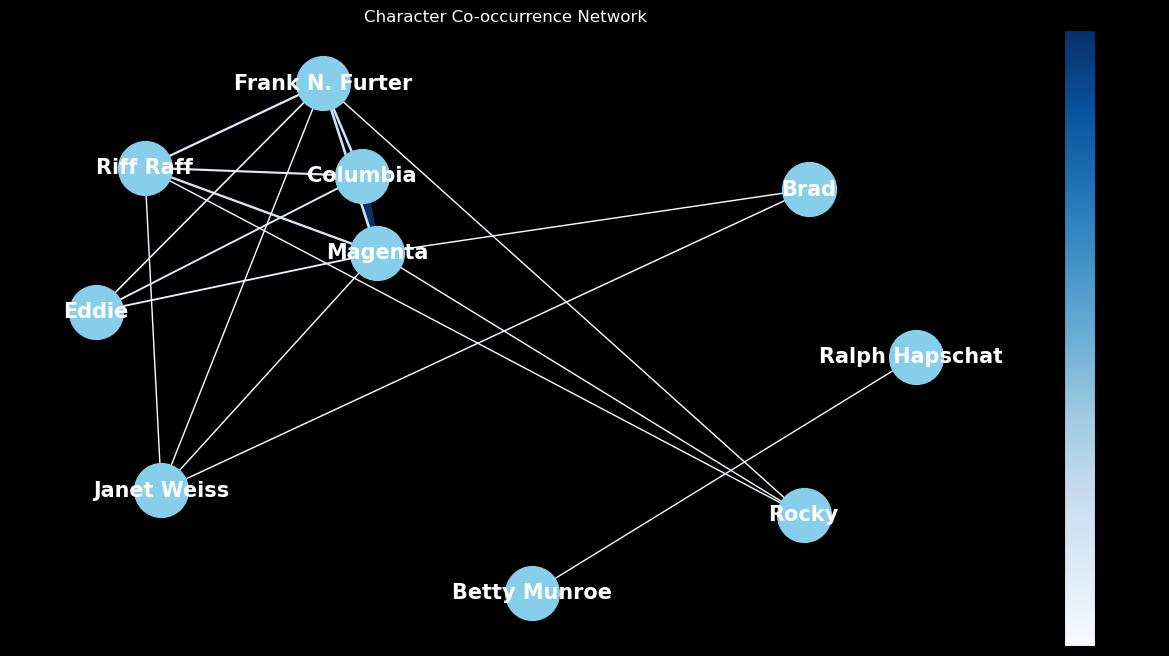

In [1]:
import re##Used for regular expression operations
import pandas as pd ##For data processing and analysis
import json##Used to read JSON files.
import networkx as nx##It is used to create a network and calculate network characteristics
import matplotlib.pyplot as plt## Provides plotting functionalities to visualize data.
from matplotlib.colors import Normalize##Provide tools for normalizing colors and creating color maps for visualization.
from matplotlib.cm import ScalarMappable
from operator import itemgetter##Used to extract specific items from objects, like sorting dictionaries.

##Reads a text file and splits it into sentences.
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
   ##Splits the text into sentences using regular expressions that identify sentence-ending punctuation.
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

## Extracts sentences that mention more than one character name variant.
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

##Loads a dictionary of character name variants from a JSON file.
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

##Loads a dictionary of verb scores from a JSON file.
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

##Scores sentences based on the presence of specific verbs.
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

##Extracts character names mentioned in a given sentence.

def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

## Visualizes the network of character co-occurrences based on the provided sentences.

def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)

##For each sentence with more than one character, creates edges between characters.
##The edge weight is determined by the sentence's score.       
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)

    ##Calculate the "degree" of each node
    ##Adds the degree value of each node as an attribute of that node
    degree_dict = dict(G.degree(G.nodes()))
    nx.set_node_attributes(G, degree_dict, 'degree')
    sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)


    print("Top 3 nodes by degree:")
    for d in sorted_degree[:3]:
        print(d)

    #Calculate network density.
    density = nx.density(G)
    print("Network density:", density)
    pos = nx.spring_layout(G, k=10, iterations=50)
    #Get the data for the edges and calculate the weights
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    
    plt.figure(figsize=(16, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    ##Draw nodes, node labels, and edges in a network diagram.
    nx.draw_networkx_nodes(G, pos, node_size=1500, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    ##Add a color bar to the color mapping of edges
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()


def main():
 ##Read the Text File:
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/10608912.txt')

 ##Load the Character Variants Dictionary:   
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

 ##Extract Sentences with Multiple Names:   
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

 ##Load the Verb Score Dictionary:   
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

##Score the Sentences:    
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()
